<a href="https://colab.research.google.com/github/Juancarlos56/Repositorio-Simulacion-10/blob/main/Evaluaciones/Segundo-Interciclo/Prueba4_Simpy_Simulacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Distribucion de Probabilidad

In [52]:
import simpy
import random
import matplotlib.pyplot as plt
from numpy import random as nprandom

#Distribucion Binomial
def tipoVehiculo():
    return nprandom.binomial(n=1, p=0.15, size=10)

#Distribucion Binomial
def tipoVehiculoParaRevision():
    return nprandom.binomial(n=1, p=0.15, size=1)

#Distribucion Binomial
def pasoRevisionVehiculo():
    return nprandom.binomial(n=1, p=0.6, size=1)

#Distribucion normal
def entrada_a_revision():
    return abs(random.normalvariate(20, 10))

### Simulación Eventos Discretos

In [49]:
import simpy
import random
import matplotlib.pyplot as plt

# Maximo de vehiculos que puede recibir el negocio
MAX_VEHICULOS = 57 
# Total de maquinas de lavado con que cuenta el negocio
NUM_Carriles = 3
# Tiempo que tarda en en llegada del vehiculo(minutos)
TIEMPO_Revision = 9 
# Intervalo de tiempo en que llegan vehiculos (minutos)
INTERVALO_LLEGADA = 3
# Tiempo de simulación
TIEMPO_SIMULACION = 1440*30
#Tipos de Vehiculos
TIPOS_VEHICULOS = ['BUS','BUSETAS', 'CAMIONES']

# Creamos un diccionario para almacenar las horas en que se lavan los vehiculos
# Esto permite graficar o generar los resultados
tiempo={}

class EMOV(object):
    
    def __init__(self, environment, numeroCarrile):
        # Guardamos como variable el entorno de ejecucion
        self.env=environment
        # Creamos el recurso que representa las carriles
        self.carriles = simpy.Resource(environment, numeroCarrile)
    
    def salidaEMOV(self):
      yield self.env.timeout(random.randint(5,10))

    def pago_revision(self):
      yield self.env.timeout(random.randint(1,3))

    def realizarReparacion(self):
        yield self.env.timeout(1440*2)

    def pasoRevision(self, nombre):
        print("Verificacion de paso de vihiculo %s a revision a la hora: %.2f." % (nombre, env.now))
        
        revision = pasoRevisionVehiculo()
        ## 0 pasa la revision y 1 no pasa
        if(revision == 0):
          print('Paso Revision vehicular %s terminada  a la hora: %.2f.' % (nombre, env.now))
        elif(revision == 1): 
          print('No paso Revision vehicular %s terminada  a la hora: %.2f.' % (nombre, env.now))
          while True:
            print('Se parquea y empieza a reparar: %d' % self.env.now)
            # Esperamos a que el proceso de recarga termine
            yield self.env.process(self.realizarReparacion())
            print('Se termino el proceso de reparacion %d a nuevamente el proceso de revision' % self.env.now)
            self.pasoRevision(nombre)

    def revision_vehiculo(self, nombre, tipoVehiculo):
        print("Entro vihiculo %s a revision a la hora: %.2f." % (nombre, env.now))
        yield self.env.timeout(entrada_a_revision())
        print('Revision vehicular %s terminada  a la hora: %.2f.' % (nombre, env.now))

    def llegadaVehiculo_estacionamiento(self, nombre, tipoVehiculo):
        print('Llega vehiculo: %s de tipo: %s,a la recepcion a la hora %.2f.' % (nombre, tipoVehiculo, env.now))
        yield self.env.timeout(random.randint(3,5))
        print('Termina vehiculo: %s de estacionarse en la hora %.2f.' % (nombre, env.now))

    def llegdaVehiculo_sacaTurno(self, nombre, tipoVehiculo):
        print('Saca Turno: %s de tipo: %s, a la hora %.2f.' % (nombre, tipoVehiculo, env.now))
        yield self.env.timeout(random.randint(1,3))
        print('Termina vehiculo: %s de sacar  turno en la hora %.2f.' % (nombre, env.now))

    def llegdaVehiculo_pagoMatricula(self, nombre, tipoVehiculo):
        print('matricula vehiculo: %s de tipo: %s,a la hora %.2f.' % (nombre, tipoVehiculo, env.now))
        yield self.env.timeout(random.randint(5,10))
        print('Termina vehiculo: %s de matricularse en la hora %.2f.' % (nombre, env.now))
    
def llegada_vehiculo(env, nombre, emov, tipoVehiculo):
    # Especificamos que vamos a usar un recurso (Resource) que representa
    # la maquina de lavado
    
    with emov.carriles.request() as carril:
        # Ocupamos EL CARRIL de lavado
        yield carril
        print("LLegada del vehiculo %s a las %.2f."%(nombre, env.now))
        yield env.process(emov.llegadaVehiculo_estacionamiento(nombre,tipoVehiculo))
        yield env.process(emov.llegdaVehiculo_sacaTurno(nombre,tipoVehiculo))
        yield env.process(emov.llegdaVehiculo_pagoMatricula(nombre,tipoVehiculo))
        print("Termina proceso de llegada del vehiculo %s a la hora: %.2f." %(nombre, env.now))
        
        yield env.process(emov.revision_vehiculo(nombre, tipoVehiculo))
        
        # Una vez que termina la llamada con 'yield', se indica que se ha lavado el vehiculo
        #print('Vehiculo [%s] lavado a las %.2f.' % (nombre, env.now))
        # --> Agegamos al diccionario para obtener los tiempos de lavado
        k=env.now # Permite obtener el tiempo actual de la simulación para generar la clave del diccionario

    if k in tiempo:
        tiempo[k]=tiempo[k]+1 # Aumento el numero de autos en el tiempo de salida
    else:
        tiempo[k]=1 # Por defecto empezamos con el primer vehiculo

def ejecutar_simulacion(env, numeroCarrile, tiempoMinimoRevesion, intervaloLlegada):
    emov=EMOV(env, numeroCarrile)
    # Creamos 5 llegadas de vehiculos iniciales
    for i in range(5):
        tipoVehiculo = tipoVehiculoParaRevision()
        if(tipoVehiculo == 1):
          vehiculo = TIPOS_VEHICULOS[random.randint(0,2)]
        elif(tipoVehiculo == 0):
          vehiculo = 'Normal' 

        env.process(llegada_vehiculo(env, 'Vehiculo-%d'%(i+1),emov, vehiculo))
    
    # Ejecutamos la simulacion
    while True:
        yield env.timeout(3)
        i+=1
        # Mientras se REVISAN los vehiculos generamos mas vehiculos
        tipoVehiculo = tipoVehiculoParaRevision()
        if(tipoVehiculo == 1):
          vehiculo = TIPOS_VEHICULOS[random.randint(0,2)]
        elif(tipoVehiculo == 0):
          vehiculo = 'Normal' 
        env.process(llegada_vehiculo(env,'Vehiculo-%d'%(i+1),emov, vehiculo))



In [50]:

print('EMOV - Juan Barrera')
# Inicializamos la semilla aleatoria
random.seed(77)

# Creamos el entorno de simulacion
env=simpy.Environment()
env.process(ejecutar_simulacion(env, NUM_Carriles, TIEMPO_Revision, INTERVALO_LLEGADA))

# Ejecutamos el proceso durante el tiempo de simulacion
env.run(until = TIEMPO_SIMULACION)

tiempoCon3Maquinas = tiempo

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Revision vehicular Vehiculo-3350 terminada  a la hora: 37626.08.
LLegada del vehiculo Vehiculo-3353 a las 37626.08.
Llega vehiculo: Vehiculo-3353 de tipo: Normal,a la recepcion a la hora 37626.08.
Termina vehiculo: Vehiculo-3352 de matricularse en la hora 37627.75.
Termina proceso de llegada del vehiculo Vehiculo-3352 a la hora: 37627.75.
Entro vihiculo Vehiculo-3352 a revision a la hora: 37627.75.
Revision vehicular Vehiculo-3349 terminada  a la hora: 37628.96.
LLegada del vehiculo Vehiculo-3354 a las 37628.96.
Llega vehiculo: Vehiculo-3354 de tipo: BUSETAS,a la recepcion a la hora 37628.96.
Revision vehicular Vehiculo-3352 terminada  a la hora: 37629.80.
LLegada del vehiculo Vehiculo-3355 a las 37629.80.
Llega vehiculo: Vehiculo-3355 de tipo: Normal,a la recepcion a la hora 37629.80.
Termina vehiculo: Vehiculo-3353 de estacionarse en la hora 37631.08.
Saca Turno: Vehiculo-3353 de tipo: Normal, a la hora 37631.08.
Term

### Graficas/Reportes

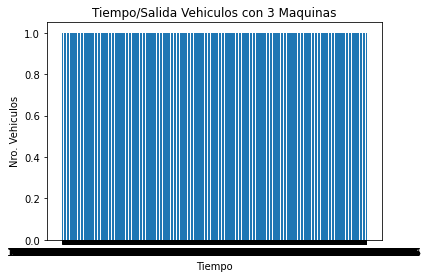

In [51]:
# Generamos una grafica en base al diccionario del tiempo con 3 maquinas
etiqueta = list(tiempoCon3Maquinas.keys())
valores = list(tiempoCon3Maquinas.values())
plt.bar(range(len(tiempoCon3Maquinas)), valores, align="center", tick_label=etiqueta)
plt.title("Tiempo/Salida Vehiculos con 3 carriles")
plt.xlabel("Tiempo")
plt.ylabel("Nro. Vehiculos")
plt.show()

### Análisis y resultados